<a href="https://colab.research.google.com/github/escuccim/vaegan-pytorch/blob/master/Vaegan_Densenet_169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt, colors
%matplotlib inline
import zipfile
import os
import matplotlib.animation as animation
import torchvision.utils as vutils
import numpy as np
import re
import random
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch import Tensor
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
import progressbar
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid
from sklearn.metrics import f1_score
import torchvision.utils as vutils
from collections import OrderedDict
from torch.hub import load_state_dict_from_url

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'gan-faces'

!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
model_save_path = "vaegan_dn169_1.pt"
disc_opt_save_path = "vaegan_dn169_opt_disc_1.pt"
enc_opt_save_path = "vaegan_dn169_opt_enc_1.pt"
dec_opt_save_path = "vaegan_dn169_opt_dec_1.pt"

In [3]:
!gsutil cp gs://{bucket_name}/{model_save_path} ./{model_save_path} 
!gsutil cp gs://{bucket_name}/{disc_opt_save_path} ./{disc_opt_save_path} 
!gsutil cp gs://{bucket_name}/{dec_opt_save_path} ./{dec_opt_save_path} 
!gsutil cp gs://{bucket_name}/{enc_opt_save_path} ./{enc_opt_save_path} 

Copying gs://gan-faces/vaegan_dn169_1.pt...
| [1 files][153.7 MiB/153.7 MiB]                                                
Operation completed over 1 objects/153.7 MiB.                                    
Copying gs://gan-faces/vaegan_dn169_opt_disc_1.pt...
- [1 files][ 48.0 MiB/ 48.0 MiB]                                                
Operation completed over 1 objects/48.0 MiB.                                     
Copying gs://gan-faces/vaegan_dn169_opt_dec_1.pt...
- [1 files][ 53.3 MiB/ 53.3 MiB]                                                
Operation completed over 1 objects/53.3 MiB.                                     
Copying gs://gan-faces/vaegan_dn169_opt_enc_1.pt...
- [1 files][ 51.0 MiB/ 51.0 MiB]                                                
Operation completed over 1 objects/51.0 MiB.                                     


In [4]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

# if not os.path.exists("wiki_images_good.zip"):
#   !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./ 
#   zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
#   zip_ref.extractall('data/wiki_images')
#   zip_ref.close()  

# if not os.path.exists("celeb_a_good.zip"):
# #   !kaggle datasets download -d jessicali9530/celeba-dataset
#   !gsutil cp gs://{bucket_name}/celeb_a_good.zip ./celeb_a_good.zip
#   zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
#   zip_ref.extractall('data/images/celeb_a')
#   zip_ref.close()

# if not os.path.exists("Training_Pictures.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
#   zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
#   zip_ref.extractall('data/images/training')
#   zip_ref.close()
  
# if not os.path.exists("imdb_crop_good.zip"):  
#   !gsutil cp gs://{bucket_name}/imdb_crop_good.zip ./imdb_crop_good.zip
#   zip_ref = zipfile.ZipFile('imdb_crop_good.zip', 'r')
#   zip_ref.extractall('data/images/imdb')
#   zip_ref.close()

# if not os.path.exists("crop_part1_good.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_good.zip ./crop_part1_good.zip
#   zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
#   zip_ref.extractall('data/images/crop_parta')
#   zip_ref.close()   

Copying gs://gan-faces/celeba-dataset.zip...
/ [1 files][  1.2 GiB/  1.2 GiB]   74.2 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [5]:
if not os.path.exists("crop_part1_good.zip"):
  !gsutil cp gs://pneumonia/crop_part1_good.zip ./crop_part1_good.zip
  zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
  zip_ref.extractall('data/test_images/crop_parta')
  zip_ref.close()   

# !gsutil cp crop_part1_good.zip  gs://{bucket_name}/crop_part1_good.zip 

Copying gs://pneumonia/crop_part1_good.zip...
- [1 files][ 49.4 MiB/ 49.4 MiB]                                                
Operation completed over 1 objects/49.4 MiB.                                     


In [0]:
model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}

In [0]:
def masked_f1_score(outputs, labels):
    # mins, _ = labels.min(dim=1)
    mask = labels != -1
    f1 = f1_score(torch.squeeze(labels[mask].detach().cpu().float().view(-1)), torch.round(outputs[mask].detach().cpu().float().view(-1)), average="micro")
    return f1

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.LeakyReLU(0.2, inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.LeakyReLU(0.2, inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    # @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(*inputs)

        return cp.checkpoint(closure, input)

    # @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    # @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class _DenseBlock(nn.Module):
    _version = 2
    __constants__ = ['layers']

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleDict()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.layers['denselayer%d' % (i + 1)] = layer

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.layers.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

    @torch.jit.ignore
    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        version = local_metadata.get('version', None)
        if (version is None or version < 2):
            # now we have a new nesting level for torchscript support
            for new_key in self.state_dict().keys():
                # remove prefix "layers."
                old_key = new_key[len("layers."):]
                old_key = prefix + old_key
                new_key = prefix + new_key
                if old_key in state_dict:
                    value = state_dict[old_key]
                    del state_dict[old_key]
                    state_dict[new_key] = value
        super(_DenseBlock, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

class DenseNet(torchvision.models.densenet.DenseNet):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    __constants__ = ['features']
    
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.LeakyReLU(0.2, inplace=True)),
            ('pool0', nn.AvgPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        features = self.features(x)
        feature_map = F.relu(features, inplace=False)
        out = F.adaptive_avg_pool2d(feature_map, (1, 1))
        out = torch.flatten(out, 1)
        output = self.classifier(out, feature_map=features)
        return output
    
def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model        
        
def densenet169(pretrained=False, progress=True, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)   

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=0, bias=False):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride,
                                       bias=bias)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=False)

    def forward(self, ten):
        c1 = self.conv(ten)
        bn = self.bn(c1)
        relu = self.relu(bn)
        return relu
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=256, ngf=64, ngpu=1):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_dim, ngf * 12, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 12),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*8) x 5 x 5
            nn.ConvTranspose2d(ngf * 12, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*4) x 10 x 10
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*2) x 20 x 20
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf) x 40 x 40
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf) x 80 x 80
            nn.ConvTranspose2d( ngf * 1, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 160 x 160
        )

    def forward(self, input):
        return self.main(input.view(input.shape[0], -1, 1, 1))
    
class DiscriminatorOutput(nn.Module):
    def __init__(self, num_ftrs):
        super(DiscriminatorOutput, self).__init__()
        # Two FC Layers to output discriminator and aux output
        self.discriminator = nn.Linear(num_ftrs, 1)
        self.aux = nn.Linear(num_ftrs, 40)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, features, feature_map=None):
        output = self.discriminator(features)
        aux_output = self.aux(features)
        
        return self.sigmoid(output), feature_map, self.sigmoid(aux_output)

class EncoderOutput(nn.Module):
    def __init__(self, num_ftrs, latent_dim=256):
        super(EncoderOutput, self).__init__()
        # Two FC Layers to output code and logvar
        self.code = nn.Linear(num_ftrs, latent_dim)
        self.logvar = nn.Linear(num_ftrs, latent_dim)
        
    def forward(self, features, feature_map=None):
        code = self.code(features)
        logvar = self.logvar(features)
        return code, logvar

class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=5):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        
        self.encoder = densenet169(pretrained=True)
        num_ftrs = self.encoder.classifier.in_features
        self.encoder.classifier = EncoderOutput(num_ftrs=num_ftrs, latent_dim=z_size)   

        self.decoder = Decoder(latent_dim=self.z_size, ngf=64)
        
        self.discriminator = densenet169(pretrained=True)
        num_ftrs = self.discriminator.classifier.in_features
        self.discriminator.classifier = DiscriminatorOutput(num_ftrs=num_ftrs)
        
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)  

    def forward(self, ten, gen_size=10):
        if self.training:
            # save the original images
            ten_original = ten
            
            # encode
            mus, log_variances = self.encoder(ten)
#             print("Encoded")
            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            
            # sample from a gaussian
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            
            # shift and scale using the means and variances
            ten = ten_from_normal * variances + mus

            # decode the tensor
            ten = self.decoder(ten)
#             print("Decoded")
            
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            ten_from_normal = self.decoder(ten_from_normal)
            #discriminator
            disc_out, fm, aux_out = self.discriminator(torch.cat((ten, ten_original,ten_from_normal), 0))
                  
            return ten, disc_out, aux_out, fm, mus, log_variances

        else:
            if ten is None:
                # just sample and decode

                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                # we need the true variances, not the log one
                variances = torch.exp(log_variances * 0.5)
                # sample from a gaussian

                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                # shift and scale using the means and variances
                ten = ten_from_normal * variances + mus
                # decode the tensor
                ten = self.decoder(ten)
            return ten
   
    @staticmethod
    def weighted_bce(outputs, labels):
        mins, _ = labels.min(dim=1)
        mask = mins != -1
        criterion = torch.nn.BCELoss(reduction="none")
        loss = criterion(torch.squeeze(outputs[mask]), labels[mask])
        weights = 1 # labels + 1
        loss = (loss * weights).mean()
        return loss

    
    @staticmethod
    def loss(ten_original, ten_predicted, layer_original, layer_predicted,layer_sampled, labels_original,
             labels_predicted,labels_sampled, mus, variances, aux_out, aux_labels):
        """
        :param ten_original: original images
        :param ten_predicted:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predicted.view(len(ten_predicted), -1)) ** 2
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        # mse between intermediate layers for both
        mse_1 = torch.sum(0.5*(layer_original - layer_predicted) ** 2, 1)
        mse_2 = torch.sum(0.5*(layer_original - layer_sampled) ** 2, 1)
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original

        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)
        bce_dis_recon = -torch.log(1 - labels_predicted+ 1e-3)

        #bce_gen_original = -torch.log(1-labels_original + 1e-3)
        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        bce_gen_recon = -torch.log(labels_predicted+ 1e-3)
        
        aux_loss = VaeGan.weighted_bce(aux_out, aux_labels.float())
        
        return nle, kl, mse_1,mse_2,\
               bce_dis_original, bce_dis_sampled,bce_dis_recon,bce_gen_sampled,bce_gen_recon, aux_loss         

In [0]:
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [6]:
image_labels = pd.read_csv("data/list_attr_celeba.csv")
# labels[labels == -1] = 0
feature_columns = image_labels.columns[1:]
num_classes = len(feature_columns)
print(num_classes)
image_labels.replace(-1, 0, inplace=True)
image_labels[feature_columns] = image_labels[feature_columns].astype(float)

class labelledDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # get the label from the data
        targets = image_labels[image_labels['image_id'] == path.split("/")[-1]][['5_o_Clock_Shadow', 'Arched_Eyebrows', 
            'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
            'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
            'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
            'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
            'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
            'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
            'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
            'Wearing_Necklace', 'Wearing_Necktie', 'Young']].values
        
        if len(targets) == 0:
            targets = np.random.binomial(1, 0.5, 40).astype(float)
            # Use -1 if we will be masking items that don't have labels
#             targets = np.array([-1.] * 40).astype(float)
        else:
            targets = targets[0]
        
        return sample, targets
    
BATCH_SIZE = batch_size = 12
data_path = "data/images"
image_size = (160,160)

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
     torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)), 
     torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=2, translate=(0.05,0.05), scale=(0.95,1.05), shear=2, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = labelledDataset(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=7,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    num_workers=7,
    shuffle=True
)

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params       

40


In [0]:
z_size = 256
recon_level = 4
decay_lr = 0.75
lambda_mse = 1e-6
lr = 3e-4
decay_margin = 1
decay_equilibrium = 1

net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

margin = 0.35
equilibrium = 0.68
#mse_lambda = 1.0
# OPTIM-LOSS
# an optimizer for each of the sub-networks, so we can selectively backprop
#optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
#lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)
#optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)
#lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
#optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)
#lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)

In [0]:
model_save_path = "vaegan_dn169_1.pt"
disc_opt_save_path = "vaegan_dn169_opt_disc_1.pt"
enc_opt_save_path = "vaegan_dn169_opt_enc_1.pt"
dec_opt_save_path = "vaegan_dn169_opt_dec_1.pt"

In [0]:
net.load_state_dict(torch.load(model_save_path), strict=False)
optimizer_encoder.load_state_dict(torch.load(enc_opt_save_path))
optimizer_decoder.load_state_dict(torch.load(dec_opt_save_path))
optimizer_discriminator.load_state_dict(torch.load(disc_opt_save_path))

In [10]:
def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params        

# print("Autoencoder Params:", count_params(netG))
print("Encoder Params:", count_params(net.encoder))
print("Decoder Params:", count_params(net.decoder))
print("Discriminator Params:", count_params(net.discriminator))

Encoder Params: 13336960
Decoder Params: 13965696
Discriminator Params: 12552745


In [0]:
decay_mse = 1
decay_equilibrium = 1
margin = 0.35
equilibrium = 0.68

def train(net, n_epochs=5, train_loader=train_loader):
    lambda_mse = 1e-6
    lambda_aux = 0.25
    decay_mse = 1
    decay_equilibrium = 1
    margin = 0.35
    equilibrium = 0.68

    try:
        for i in range(n_epochs):
            # reset rolling average
            loss_nle_mean = RollingMeasure()
            loss_encoder_mean = RollingMeasure()
            loss_decoder_mean = RollingMeasure()
            loss_discriminator_mean = RollingMeasure()
            loss_reconstruction_layer_mean = RollingMeasure()
            loss_kld_mean = RollingMeasure()
            gan_gen_eq_mean = RollingMeasure()
            gan_dis_eq_mean = RollingMeasure()
            aux_f1 = RollingMeasure()
            
            #print("LR:{}".format(lr_encoder.get_lr()))

            # for each batch
            for j, (data_batch,aux_labels) in enumerate(train_loader):
                # set to train mode
                train_batch = len(data_batch)
                net.train()
                # target and input are the same images
                data_in = Variable(data_batch, requires_grad=False).float().cuda()
                data_target = data_in.clone()
                aux_labels = aux_labels.cuda()

                # get output
                out, out_labels, aux_out, out_layer, mus, variances = net(data_in)

                # split so we can get the different parts
                out_layer_predicted = out_layer[:train_batch]
                out_layer_original = out_layer[train_batch:-train_batch]
                out_layer_sampled = out_layer[-train_batch:]

                #labels
                out_labels_predicted = out_labels[:train_batch]
                out_labels_original = out_labels[train_batch:-train_batch]
                out_labels_sampled = out_labels[-train_batch:]

                aux_out = aux_out[train_batch:-train_batch]
                # loss, nothing special here
                nle_value, kl_value, mse_value_1,mse_value_2, bce_dis_original_value, bce_dis_sampled_value, \
                bce_dis_predicted_value,bce_gen_sampled_value,bce_gen_predicted_value, aux_loss = VaeGan.loss(data_target, out, out_layer_original,
                                                                              out_layer_predicted,out_layer_sampled, out_labels_original,
                                                                              out_labels_predicted,out_labels_sampled, mus,
                                                                              variances, aux_out, aux_labels)
                # THIS IS THE MOST IMPORTANT PART OF THE CODE
                loss_encoder = torch.sum(kl_value)+torch.sum(mse_value_1)+torch.sum(mse_value_2)
                loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value)+ torch.sum(bce_dis_predicted_value) + (lambda_aux * aux_loss)
                loss_decoder = torch.sum(bce_gen_sampled_value) + torch.sum(bce_gen_predicted_value)
                loss_decoder = torch.sum(lambda_mse/2 * mse_value_1)+ torch.sum(lambda_mse/2 * mse_value_2) + (1.0 - lambda_mse) * loss_decoder

                # register mean values of the losses for logging
                loss_nle_mean(torch.mean(nle_value).data.cpu().item())
                loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).data.cpu().item())
                loss_decoder_mean((torch.mean(lambda_mse * mse_value_1/2)+torch.mean(lambda_mse * mse_value_2/2) + (1 - lambda_mse) * (torch.mean(bce_gen_predicted_value) + torch.mean(bce_gen_sampled_value))).data.cpu().item())

                aux_f1(masked_f1_score(aux_out, aux_labels))

                loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value_1)+ torch.mean(mse_value_2)).data.cpu().item())
                loss_reconstruction_layer_mean((torch.mean(mse_value_1)+torch.mean(mse_value_2)).data.cpu().item())
                loss_kld_mean(torch.mean(kl_value).data.cpu().item())
                # selectively disable the decoder of the discriminator if they are unbalanced
                train_dis = True
                train_dec = True
                if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
                    train_dis = False
                if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
                    train_dec = False
                if train_dec is False and train_dis is False:
                    train_dis = True
                    train_dec = True

                #aggiungo log
                if train_dis:
                    gan_dis_eq_mean(1.0)
                else:
                    gan_dis_eq_mean(0.0)

                if train_dec:
                    gan_gen_eq_mean(1.0)
                else:
                    gan_gen_eq_mean(0.0)

                # BACKPROP
                # clean grads
                net.zero_grad()
                # encoder
                loss_encoder.backward(retain_graph=True)
                # someone likes to clamp the grad here
                #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
                # update parameters
                optimizer_encoder.step()
                # clean others, so they are not afflicted by encoder loss
                net.zero_grad()
                #decoder
                if train_dec:
                    loss_decoder.backward(retain_graph=True)
                    #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                    optimizer_decoder.step()
                    #clean the discriminator
                    net.discriminator.zero_grad()
                #discriminator
                if train_dis:
                    loss_discriminator.backward()
                    #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                    optimizer_discriminator.step()

                if j % 100 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_Dec: %.4f\tAux F1: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                          % (i, n_epochs, j, len(train_loader),
                              loss_discriminator_mean.measure,  loss_decoder_mean.measure, aux_f1.measure, loss_encoder_mean.measure, out_labels_original.mean().item(), out_labels_predicted.mean().item()))
                if j % 500 == 0 and j > 0:
                    with torch.no_grad():
                      out = (out * 0.5) + 0.5
                      fig, ax = plt.subplots(1, 2, figsize=(7,7))
                      ax[0].imshow(np.transpose(vutils.make_grid(out[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                      ax[1].imshow(np.transpose(vutils.make_grid(data_in[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                      plt.show()

            torch.save(net.state_dict(), model_save_path)
            torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
            torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
            torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

            lr_encoder.step()
            lr_decoder.step()
            lr_discriminator.step()
            margin *=decay_margin
            equilibrium *=decay_equilibrium
            #margin non puo essere piu alto di equilibrium
            if margin > equilibrium:
                equilibrium = margin
            lambda_mse *=decay_mse
            if lambda_mse > 1:
                lambda_mse=1

            # plot some sample images
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            out = (out * 0.5) + 0.5
            ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()   
            
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(net.state_dict(), model_save_path)
        torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
        torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
        torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

    !gsutil cp ./{model_save_path} gs://{bucket_name}/{model_save_path}
    !gsutil cp ./{disc_opt_save_path} gs://{bucket_name}/{disc_opt_save_path}
    !gsutil cp ./{dec_opt_save_path} gs://{bucket_name}/{dec_opt_save_path}
    !gsutil cp ./{enc_opt_save_path} gs://{bucket_name}/{enc_opt_save_path}

[0/1][0/16884]	Loss_D: 2.6302	Loss_Dec: 1.7875	Aux F1: 0.8062	Loss_Enc: 4096.6997	D(x): 0.2679	D(G(z)): 0.3849
[0/1][100/16884]	Loss_D: 1.2212	Loss_Dec: 2.8773	Aux F1: 0.8053	Loss_Enc: 2749.6824	D(x): 0.6265	D(G(z)): 0.2142
[0/1][200/16884]	Loss_D: 1.2199	Loss_Dec: 2.9424	Aux F1: 0.8050	Loss_Enc: 2866.7721	D(x): 0.3485	D(G(z)): 0.1926
[0/1][300/16884]	Loss_D: 1.1943	Loss_Dec: 2.9462	Aux F1: 0.8058	Loss_Enc: 2906.6880	D(x): 0.5426	D(G(z)): 0.2206
[0/1][400/16884]	Loss_D: 1.1954	Loss_Dec: 2.9427	Aux F1: 0.8062	Loss_Enc: 2960.1749	D(x): 0.2458	D(G(z)): 0.3420
[0/1][500/16884]	Loss_D: 1.1937	Loss_Dec: 2.9511	Aux F1: 0.8062	Loss_Enc: 2967.5446	D(x): 0.5003	D(G(z)): 0.3203


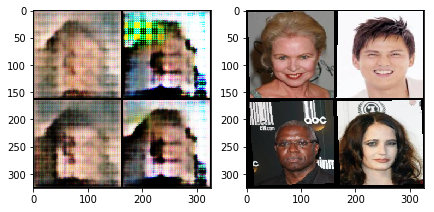

[0/1][600/16884]	Loss_D: 1.1955	Loss_Dec: 2.9542	Aux F1: 0.8065	Loss_Enc: 2967.2945	D(x): 0.4994	D(G(z)): 0.3161
[0/1][700/16884]	Loss_D: 1.1922	Loss_Dec: 2.9779	Aux F1: 0.8067	Loss_Enc: 2973.7996	D(x): 0.4741	D(G(z)): 0.3475
[0/1][800/16884]	Loss_D: 1.1890	Loss_Dec: 2.9930	Aux F1: 0.8072	Loss_Enc: 2975.4798	D(x): 0.3730	D(G(z)): 0.2866
[0/1][900/16884]	Loss_D: 1.1833	Loss_Dec: 3.0071	Aux F1: 0.8066	Loss_Enc: 2979.1180	D(x): 0.3981	D(G(z)): 0.3076
[0/1][1000/16884]	Loss_D: 1.1801	Loss_Dec: 3.0179	Aux F1: 0.8072	Loss_Enc: 2976.6153	D(x): 0.4438	D(G(z)): 0.3331


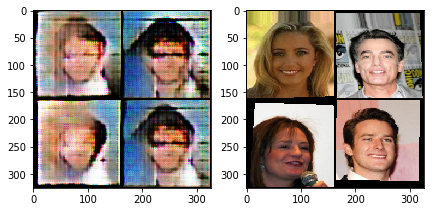

[0/1][1100/16884]	Loss_D: 1.1817	Loss_Dec: 3.0046	Aux F1: 0.8073	Loss_Enc: 2973.1069	D(x): 0.4861	D(G(z)): 0.2330
[0/1][1200/16884]	Loss_D: 1.1822	Loss_Dec: 2.9906	Aux F1: 0.8074	Loss_Enc: 2966.3558	D(x): 0.3694	D(G(z)): 0.2729
[0/1][1300/16884]	Loss_D: 1.1837	Loss_Dec: 2.9805	Aux F1: 0.8075	Loss_Enc: 2958.3260	D(x): 0.4785	D(G(z)): 0.3533
[0/1][1400/16884]	Loss_D: 1.1821	Loss_Dec: 2.9736	Aux F1: 0.8075	Loss_Enc: 2956.6015	D(x): 0.4722	D(G(z)): 0.2410
[0/1][1500/16884]	Loss_D: 1.1796	Loss_Dec: 2.9742	Aux F1: 0.8075	Loss_Enc: 2956.3232	D(x): 0.4961	D(G(z)): 0.2917


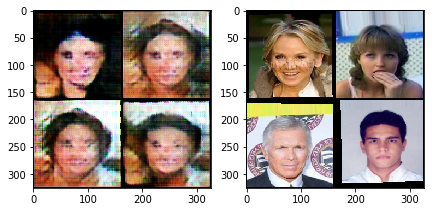

[0/1][1600/16884]	Loss_D: 1.1793	Loss_Dec: 2.9687	Aux F1: 0.8076	Loss_Enc: 2951.2718	D(x): 0.4535	D(G(z)): 0.2266
[0/1][1700/16884]	Loss_D: 1.1775	Loss_Dec: 2.9665	Aux F1: 0.8075	Loss_Enc: 2941.9684	D(x): 0.5353	D(G(z)): 0.2408
[0/1][1800/16884]	Loss_D: 1.1748	Loss_Dec: 2.9626	Aux F1: 0.8076	Loss_Enc: 2934.8122	D(x): 0.3936	D(G(z)): 0.3224
[0/1][1900/16884]	Loss_D: 1.1727	Loss_Dec: 2.9644	Aux F1: 0.8076	Loss_Enc: 2922.6729	D(x): 0.4219	D(G(z)): 0.2864
[0/1][2000/16884]	Loss_D: 1.1722	Loss_Dec: 2.9651	Aux F1: 0.8077	Loss_Enc: 2914.2597	D(x): 0.3996	D(G(z)): 0.3361


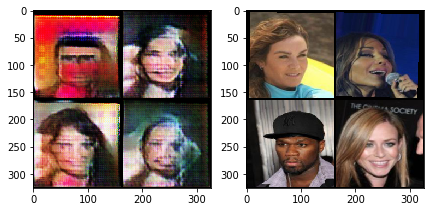

[0/1][2100/16884]	Loss_D: 1.1722	Loss_Dec: 2.9637	Aux F1: 0.8081	Loss_Enc: 2900.6814	D(x): 0.5942	D(G(z)): 0.2587
[0/1][2200/16884]	Loss_D: 1.1706	Loss_Dec: 2.9639	Aux F1: 0.8082	Loss_Enc: 2890.6897	D(x): 0.4939	D(G(z)): 0.2733
[0/1][2300/16884]	Loss_D: 1.1684	Loss_Dec: 2.9669	Aux F1: 0.8084	Loss_Enc: 2885.1470	D(x): 0.5194	D(G(z)): 0.2696
[0/1][2400/16884]	Loss_D: 1.1669	Loss_Dec: 2.9687	Aux F1: 0.8085	Loss_Enc: 2877.4646	D(x): 0.4622	D(G(z)): 0.3835
[0/1][2500/16884]	Loss_D: 1.1658	Loss_Dec: 2.9653	Aux F1: 0.8085	Loss_Enc: 2869.3032	D(x): 0.5096	D(G(z)): 0.3132


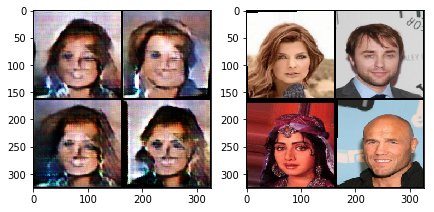

[0/1][2600/16884]	Loss_D: 1.1650	Loss_Dec: 2.9757	Aux F1: 0.8086	Loss_Enc: 2868.9732	D(x): 0.5177	D(G(z)): 0.2927
[0/1][2700/16884]	Loss_D: 1.1633	Loss_Dec: 2.9822	Aux F1: 0.8088	Loss_Enc: 2871.2769	D(x): 0.5040	D(G(z)): 0.2092
[0/1][2800/16884]	Loss_D: 1.1625	Loss_Dec: 2.9895	Aux F1: 0.8089	Loss_Enc: 2873.2144	D(x): 0.4211	D(G(z)): 0.3596
[0/1][2900/16884]	Loss_D: 1.1629	Loss_Dec: 2.9924	Aux F1: 0.8091	Loss_Enc: 2873.2657	D(x): 0.3808	D(G(z)): 0.3123
[0/1][3000/16884]	Loss_D: 1.1626	Loss_Dec: 2.9908	Aux F1: 0.8094	Loss_Enc: 2871.7029	D(x): 0.5502	D(G(z)): 0.2992


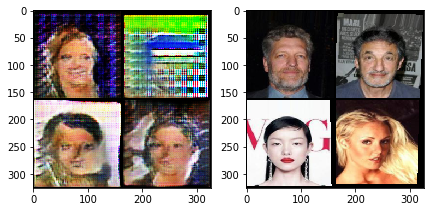

[0/1][3100/16884]	Loss_D: 1.1623	Loss_Dec: 2.9894	Aux F1: 0.8097	Loss_Enc: 2869.1406	D(x): 0.4441	D(G(z)): 0.2615
[0/1][3200/16884]	Loss_D: 1.1620	Loss_Dec: 2.9856	Aux F1: 0.8098	Loss_Enc: 2859.8722	D(x): 0.5196	D(G(z)): 0.2868
[0/1][3300/16884]	Loss_D: 1.1605	Loss_Dec: 2.9846	Aux F1: 0.8099	Loss_Enc: 2854.4951	D(x): 0.4251	D(G(z)): 0.3110
[0/1][3400/16884]	Loss_D: 1.1592	Loss_Dec: 2.9879	Aux F1: 0.8101	Loss_Enc: 2847.8662	D(x): 0.5150	D(G(z)): 0.2194
[0/1][3500/16884]	Loss_D: 1.1587	Loss_Dec: 2.9874	Aux F1: 0.8103	Loss_Enc: 2838.8555	D(x): 0.4413	D(G(z)): 0.2759


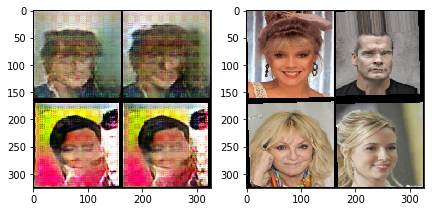

[0/1][3600/16884]	Loss_D: 1.1575	Loss_Dec: 2.9892	Aux F1: 0.8105	Loss_Enc: 2834.0392	D(x): 0.4664	D(G(z)): 0.2274
[0/1][3700/16884]	Loss_D: 1.1564	Loss_Dec: 2.9890	Aux F1: 0.8109	Loss_Enc: 2827.6534	D(x): 0.5237	D(G(z)): 0.2763
[0/1][3800/16884]	Loss_D: 1.1552	Loss_Dec: 2.9926	Aux F1: 0.8112	Loss_Enc: 2822.6337	D(x): 0.5179	D(G(z)): 0.2481
[0/1][3900/16884]	Loss_D: 1.1539	Loss_Dec: 2.9997	Aux F1: 0.8115	Loss_Enc: 2821.1626	D(x): 0.4926	D(G(z)): 0.3025
[0/1][4000/16884]	Loss_D: 1.1536	Loss_Dec: 3.0058	Aux F1: 0.8117	Loss_Enc: 2820.1014	D(x): 0.4927	D(G(z)): 0.1704


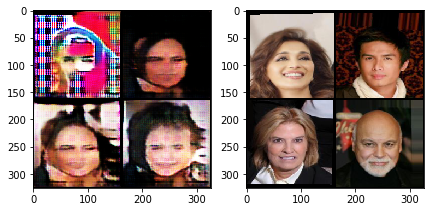

[0/1][4100/16884]	Loss_D: 1.1526	Loss_Dec: 3.0101	Aux F1: 0.8120	Loss_Enc: 2819.0450	D(x): 0.5988	D(G(z)): 0.2188
[0/1][4200/16884]	Loss_D: 1.1516	Loss_Dec: 3.0091	Aux F1: 0.8122	Loss_Enc: 2815.6738	D(x): 0.4387	D(G(z)): 0.3575
[0/1][4300/16884]	Loss_D: 1.1513	Loss_Dec: 3.0102	Aux F1: 0.8124	Loss_Enc: 2810.9957	D(x): 0.4199	D(G(z)): 0.2969
[0/1][4400/16884]	Loss_D: 1.1507	Loss_Dec: 3.0143	Aux F1: 0.8126	Loss_Enc: 2806.5835	D(x): 0.5302	D(G(z)): 0.2617
[0/1][4500/16884]	Loss_D: 1.1498	Loss_Dec: 3.0161	Aux F1: 0.8128	Loss_Enc: 2806.2465	D(x): 0.4485	D(G(z)): 0.2691


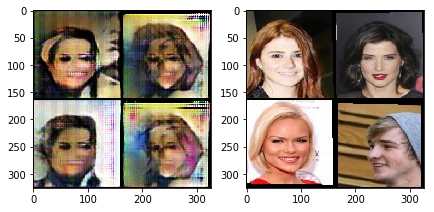

[0/1][4600/16884]	Loss_D: 1.1494	Loss_Dec: 3.0209	Aux F1: 0.8131	Loss_Enc: 2805.4543	D(x): 0.4940	D(G(z)): 0.2904
[0/1][4700/16884]	Loss_D: 1.1483	Loss_Dec: 3.0261	Aux F1: 0.8133	Loss_Enc: 2806.4056	D(x): 0.5912	D(G(z)): 0.1817
[0/1][4800/16884]	Loss_D: 1.1485	Loss_Dec: 3.0273	Aux F1: 0.8136	Loss_Enc: 2803.6036	D(x): 0.4679	D(G(z)): 0.3438
[0/1][4900/16884]	Loss_D: 1.1482	Loss_Dec: 3.0288	Aux F1: 0.8137	Loss_Enc: 2801.9962	D(x): 0.4940	D(G(z)): 0.1862
[0/1][5000/16884]	Loss_D: 1.1479	Loss_Dec: 3.0301	Aux F1: 0.8139	Loss_Enc: 2799.3211	D(x): 0.4613	D(G(z)): 0.2298


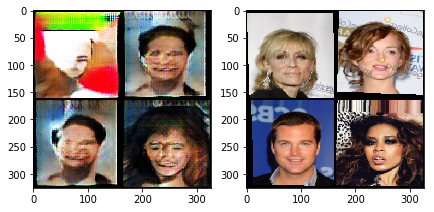

[0/1][5100/16884]	Loss_D: 1.1473	Loss_Dec: 3.0322	Aux F1: 0.8141	Loss_Enc: 2797.2379	D(x): 0.4408	D(G(z)): 0.3265
[0/1][5200/16884]	Loss_D: 1.1468	Loss_Dec: 3.0330	Aux F1: 0.8142	Loss_Enc: 2795.0023	D(x): 0.4331	D(G(z)): 0.2653
[0/1][5300/16884]	Loss_D: 1.1458	Loss_Dec: 3.0381	Aux F1: 0.8144	Loss_Enc: 2795.1883	D(x): 0.5601	D(G(z)): 0.2018
[0/1][5400/16884]	Loss_D: 1.1443	Loss_Dec: 3.0444	Aux F1: 0.8146	Loss_Enc: 2794.0044	D(x): 0.5430	D(G(z)): 0.2260
[0/1][5500/16884]	Loss_D: 1.1428	Loss_Dec: 3.0503	Aux F1: 0.8147	Loss_Enc: 2792.6967	D(x): 0.4813	D(G(z)): 0.2818


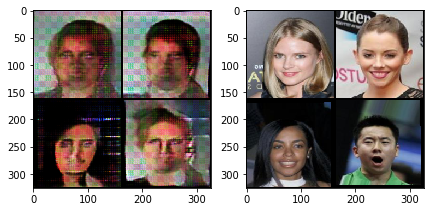

[0/1][5600/16884]	Loss_D: 1.1412	Loss_Dec: 3.0567	Aux F1: 0.8148	Loss_Enc: 2790.7982	D(x): 0.5543	D(G(z)): 0.2827
[0/1][5700/16884]	Loss_D: 1.1407	Loss_Dec: 3.0559	Aux F1: 0.8149	Loss_Enc: 2788.8967	D(x): 0.2831	D(G(z)): 0.5212
[0/1][5800/16884]	Loss_D: 1.1405	Loss_Dec: 3.0562	Aux F1: 0.8151	Loss_Enc: 2787.0515	D(x): 0.4172	D(G(z)): 0.3279
[0/1][5900/16884]	Loss_D: 1.1408	Loss_Dec: 3.0554	Aux F1: 0.8152	Loss_Enc: 2785.0445	D(x): 0.4274	D(G(z)): 0.2506
[0/1][6000/16884]	Loss_D: 1.1403	Loss_Dec: 3.0562	Aux F1: 0.8153	Loss_Enc: 2784.5212	D(x): 0.5802	D(G(z)): 0.2270


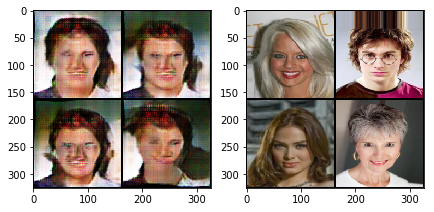

[0/1][6100/16884]	Loss_D: 1.1403	Loss_Dec: 3.0563	Aux F1: 0.8155	Loss_Enc: 2782.3270	D(x): 0.4730	D(G(z)): 0.3030
[0/1][6200/16884]	Loss_D: 1.1400	Loss_Dec: 3.0559	Aux F1: 0.8157	Loss_Enc: 2781.0503	D(x): 0.4900	D(G(z)): 0.3283
[0/1][6300/16884]	Loss_D: 1.1399	Loss_Dec: 3.0559	Aux F1: 0.8158	Loss_Enc: 2781.0757	D(x): 0.4688	D(G(z)): 0.2344
[0/1][6400/16884]	Loss_D: 1.1395	Loss_Dec: 3.0582	Aux F1: 0.8160	Loss_Enc: 2782.4179	D(x): 0.3927	D(G(z)): 0.4087
[0/1][6500/16884]	Loss_D: 1.1390	Loss_Dec: 3.0589	Aux F1: 0.8161	Loss_Enc: 2780.9662	D(x): 0.3988	D(G(z)): 0.3885


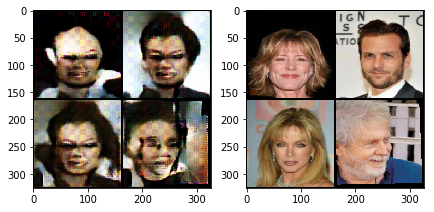

[0/1][6600/16884]	Loss_D: 1.1389	Loss_Dec: 3.0559	Aux F1: 0.8161	Loss_Enc: 2776.0191	D(x): 0.3847	D(G(z)): 0.3955
[0/1][6700/16884]	Loss_D: 1.1382	Loss_Dec: 3.0558	Aux F1: 0.8163	Loss_Enc: 2770.3527	D(x): 0.4913	D(G(z)): 0.2845
[0/1][6800/16884]	Loss_D: 1.1375	Loss_Dec: 3.0556	Aux F1: 0.8163	Loss_Enc: 2766.8152	D(x): 0.4424	D(G(z)): 0.2251
[0/1][6900/16884]	Loss_D: 1.1372	Loss_Dec: 3.0551	Aux F1: 0.8164	Loss_Enc: 2763.2660	D(x): 0.4526	D(G(z)): 0.2883
[0/1][7000/16884]	Loss_D: 1.1369	Loss_Dec: 3.0560	Aux F1: 0.8166	Loss_Enc: 2760.3588	D(x): 0.4845	D(G(z)): 0.2668


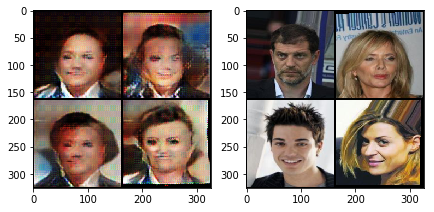

[0/1][7100/16884]	Loss_D: 1.1368	Loss_Dec: 3.0531	Aux F1: 0.8167	Loss_Enc: 2758.2249	D(x): 0.4838	D(G(z)): 0.3388
[0/1][7200/16884]	Loss_D: 1.1364	Loss_Dec: 3.0521	Aux F1: 0.8167	Loss_Enc: 2758.7556	D(x): 0.4305	D(G(z)): 0.3328
[0/1][7300/16884]	Loss_D: 1.1363	Loss_Dec: 3.0514	Aux F1: 0.8168	Loss_Enc: 2759.0885	D(x): 0.4082	D(G(z)): 0.3221
[0/1][7400/16884]	Loss_D: 1.1361	Loss_Dec: 3.0512	Aux F1: 0.8169	Loss_Enc: 2756.9513	D(x): 0.4179	D(G(z)): 0.3075
[0/1][7500/16884]	Loss_D: 1.1362	Loss_Dec: 3.0484	Aux F1: 0.8169	Loss_Enc: 2755.9437	D(x): 0.5269	D(G(z)): 0.2408


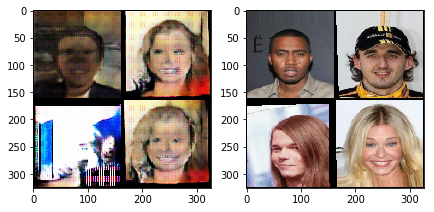

[0/1][7600/16884]	Loss_D: 1.1361	Loss_Dec: 3.0483	Aux F1: 0.8171	Loss_Enc: 2754.2152	D(x): 0.4408	D(G(z)): 0.3112
[0/1][7700/16884]	Loss_D: 1.1371	Loss_Dec: 3.0481	Aux F1: 0.8172	Loss_Enc: 2751.9484	D(x): 0.5592	D(G(z)): 0.2646
[0/1][7800/16884]	Loss_D: 1.1373	Loss_Dec: 3.0488	Aux F1: 0.8173	Loss_Enc: 2752.2684	D(x): 0.4666	D(G(z)): 0.2368
[0/1][7900/16884]	Loss_D: 1.1375	Loss_Dec: 3.0496	Aux F1: 0.8174	Loss_Enc: 2752.1155	D(x): 0.4730	D(G(z)): 0.2967
[0/1][8000/16884]	Loss_D: 1.1378	Loss_Dec: 3.0506	Aux F1: 0.8175	Loss_Enc: 2752.5522	D(x): 0.4987	D(G(z)): 0.2500


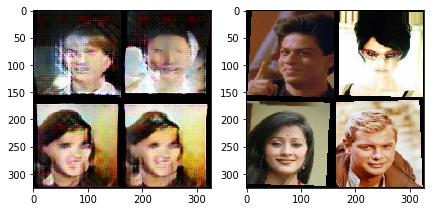

[0/1][8100/16884]	Loss_D: 1.1374	Loss_Dec: 3.0535	Aux F1: 0.8176	Loss_Enc: 2754.0427	D(x): 0.4540	D(G(z)): 0.2801
[0/1][8200/16884]	Loss_D: 1.1380	Loss_Dec: 3.0530	Aux F1: 0.8176	Loss_Enc: 2753.1000	D(x): 0.4180	D(G(z)): 0.2690
[0/1][8300/16884]	Loss_D: 1.1381	Loss_Dec: 3.0495	Aux F1: 0.8176	Loss_Enc: 2753.0078	D(x): 0.3994	D(G(z)): 0.3114
[0/1][8400/16884]	Loss_D: 1.1380	Loss_Dec: 3.0481	Aux F1: 0.8177	Loss_Enc: 2753.4674	D(x): 0.4961	D(G(z)): 0.2149
[0/1][8500/16884]	Loss_D: 1.1374	Loss_Dec: 3.0495	Aux F1: 0.8178	Loss_Enc: 2754.2498	D(x): 0.5896	D(G(z)): 0.2428


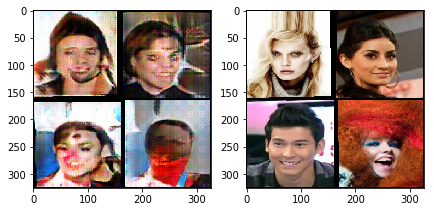

[0/1][8600/16884]	Loss_D: 1.1371	Loss_Dec: 3.0496	Aux F1: 0.8179	Loss_Enc: 2754.2965	D(x): 0.3801	D(G(z)): 0.3128
[0/1][8700/16884]	Loss_D: 1.1369	Loss_Dec: 3.0505	Aux F1: 0.8180	Loss_Enc: 2754.1123	D(x): 0.4493	D(G(z)): 0.2434
[0/1][8800/16884]	Loss_D: 1.1367	Loss_Dec: 3.0524	Aux F1: 0.8181	Loss_Enc: 2754.4514	D(x): 0.4970	D(G(z)): 0.2879
[0/1][8900/16884]	Loss_D: 1.1364	Loss_Dec: 3.0510	Aux F1: 0.8181	Loss_Enc: 2753.0649	D(x): 0.5958	D(G(z)): 0.2410
[0/1][9000/16884]	Loss_D: 1.1360	Loss_Dec: 3.0511	Aux F1: 0.8182	Loss_Enc: 2753.1786	D(x): 0.6415	D(G(z)): 0.2273


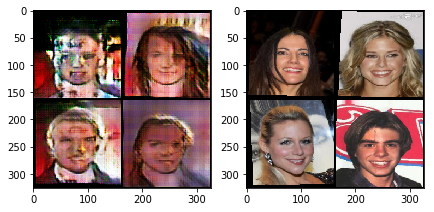

[0/1][9100/16884]	Loss_D: 1.1358	Loss_Dec: 3.0498	Aux F1: 0.8183	Loss_Enc: 2753.2652	D(x): 0.5437	D(G(z)): 0.2391
[0/1][9200/16884]	Loss_D: 1.1355	Loss_Dec: 3.0499	Aux F1: 0.8183	Loss_Enc: 2754.1143	D(x): 0.4830	D(G(z)): 0.2814
[0/1][9300/16884]	Loss_D: 1.1349	Loss_Dec: 3.0516	Aux F1: 0.8184	Loss_Enc: 2754.0768	D(x): 0.3850	D(G(z)): 0.3062
[0/1][9400/16884]	Loss_D: 1.1343	Loss_Dec: 3.0527	Aux F1: 0.8185	Loss_Enc: 2753.1795	D(x): 0.5088	D(G(z)): 0.2643
[0/1][9500/16884]	Loss_D: 1.1338	Loss_Dec: 3.0533	Aux F1: 0.8186	Loss_Enc: 2753.2102	D(x): 0.4885	D(G(z)): 0.2702


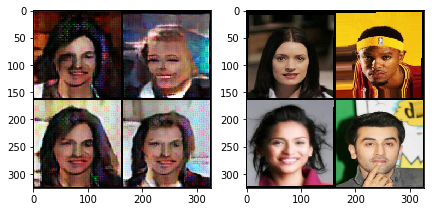

[0/1][9600/16884]	Loss_D: 1.1335	Loss_Dec: 3.0541	Aux F1: 0.8186	Loss_Enc: 2752.5546	D(x): 0.4665	D(G(z)): 0.3523
[0/1][9700/16884]	Loss_D: 1.1333	Loss_Dec: 3.0527	Aux F1: 0.8187	Loss_Enc: 2752.2502	D(x): 0.4683	D(G(z)): 0.2672
[0/1][9800/16884]	Loss_D: 1.1333	Loss_Dec: 3.0523	Aux F1: 0.8188	Loss_Enc: 2751.3735	D(x): 0.5353	D(G(z)): 0.3190
[0/1][9900/16884]	Loss_D: 1.1324	Loss_Dec: 3.0536	Aux F1: 0.8188	Loss_Enc: 2751.7105	D(x): 0.5385	D(G(z)): 0.1936
[0/1][10000/16884]	Loss_D: 1.1314	Loss_Dec: 3.0564	Aux F1: 0.8188	Loss_Enc: 2750.8716	D(x): 0.5275	D(G(z)): 0.2081


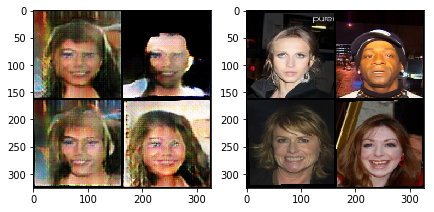

[0/1][10100/16884]	Loss_D: 1.1306	Loss_Dec: 3.0582	Aux F1: 0.8189	Loss_Enc: 2749.7016	D(x): 0.5327	D(G(z)): 0.2305
[0/1][10200/16884]	Loss_D: 1.1297	Loss_Dec: 3.0607	Aux F1: 0.8190	Loss_Enc: 2749.0114	D(x): 0.4815	D(G(z)): 0.2935
[0/1][10300/16884]	Loss_D: 1.1295	Loss_Dec: 3.0608	Aux F1: 0.8190	Loss_Enc: 2747.9886	D(x): 0.4900	D(G(z)): 0.1575
[0/1][10400/16884]	Loss_D: 1.1292	Loss_Dec: 3.0603	Aux F1: 0.8191	Loss_Enc: 2747.0083	D(x): 0.4867	D(G(z)): 0.2890
[0/1][10500/16884]	Loss_D: 1.1288	Loss_Dec: 3.0598	Aux F1: 0.8191	Loss_Enc: 2745.7177	D(x): 0.5079	D(G(z)): 0.2872


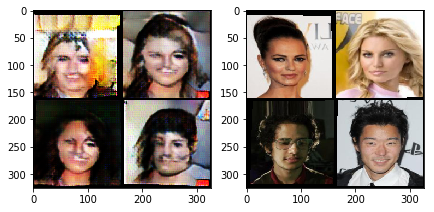

[0/1][10600/16884]	Loss_D: 1.1290	Loss_Dec: 3.0581	Aux F1: 0.8192	Loss_Enc: 2743.7671	D(x): 0.4668	D(G(z)): 0.2784
[0/1][10700/16884]	Loss_D: 1.1287	Loss_Dec: 3.0577	Aux F1: 0.8192	Loss_Enc: 2741.9935	D(x): 0.5237	D(G(z)): 0.2712
[0/1][10800/16884]	Loss_D: 1.1286	Loss_Dec: 3.0576	Aux F1: 0.8193	Loss_Enc: 2740.2938	D(x): 0.5669	D(G(z)): 0.2230
[0/1][10900/16884]	Loss_D: 1.1287	Loss_Dec: 3.0560	Aux F1: 0.8194	Loss_Enc: 2738.8248	D(x): 0.4307	D(G(z)): 0.3437
[0/1][11000/16884]	Loss_D: 1.1287	Loss_Dec: 3.0547	Aux F1: 0.8194	Loss_Enc: 2738.0511	D(x): 0.5427	D(G(z)): 0.2681


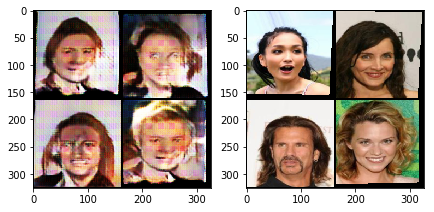

[0/1][11100/16884]	Loss_D: 1.1287	Loss_Dec: 3.0533	Aux F1: 0.8195	Loss_Enc: 2736.4458	D(x): 0.5046	D(G(z)): 0.2231
[0/1][11200/16884]	Loss_D: 1.1283	Loss_Dec: 3.0531	Aux F1: 0.8195	Loss_Enc: 2735.7948	D(x): 0.4454	D(G(z)): 0.3082
[0/1][11300/16884]	Loss_D: 1.1282	Loss_Dec: 3.0518	Aux F1: 0.8196	Loss_Enc: 2734.2770	D(x): 0.5412	D(G(z)): 0.2510
[0/1][11400/16884]	Loss_D: 1.1280	Loss_Dec: 3.0506	Aux F1: 0.8196	Loss_Enc: 2733.5792	D(x): 0.5342	D(G(z)): 0.2553
[0/1][11500/16884]	Loss_D: 1.1278	Loss_Dec: 3.0501	Aux F1: 0.8197	Loss_Enc: 2732.8870	D(x): 0.5029	D(G(z)): 0.1841


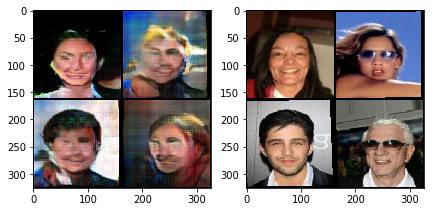

[0/1][11600/16884]	Loss_D: 1.1278	Loss_Dec: 3.0488	Aux F1: 0.8197	Loss_Enc: 2731.2458	D(x): 0.3904	D(G(z)): 0.3366
[0/1][11700/16884]	Loss_D: 1.1277	Loss_Dec: 3.0474	Aux F1: 0.8197	Loss_Enc: 2729.9009	D(x): 0.4260	D(G(z)): 0.3565
[0/1][11800/16884]	Loss_D: 1.1271	Loss_Dec: 3.0480	Aux F1: 0.8198	Loss_Enc: 2728.8275	D(x): 0.5333	D(G(z)): 0.2144
[0/1][11900/16884]	Loss_D: 1.1267	Loss_Dec: 3.0485	Aux F1: 0.8199	Loss_Enc: 2729.0268	D(x): 0.4183	D(G(z)): 0.2967
[0/1][12000/16884]	Loss_D: 1.1262	Loss_Dec: 3.0495	Aux F1: 0.8199	Loss_Enc: 2728.0158	D(x): 0.4755	D(G(z)): 0.3259


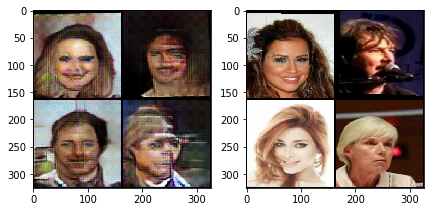

[0/1][12100/16884]	Loss_D: 1.1259	Loss_Dec: 3.0509	Aux F1: 0.8199	Loss_Enc: 2726.6894	D(x): 0.4883	D(G(z)): 0.2447
[0/1][12200/16884]	Loss_D: 1.1254	Loss_Dec: 3.0522	Aux F1: 0.8200	Loss_Enc: 2725.7165	D(x): 0.5576	D(G(z)): 0.2774
[0/1][12300/16884]	Loss_D: 1.1248	Loss_Dec: 3.0538	Aux F1: 0.8200	Loss_Enc: 2726.0945	D(x): 0.3430	D(G(z)): 0.2342
[0/1][12400/16884]	Loss_D: 1.1243	Loss_Dec: 3.0551	Aux F1: 0.8201	Loss_Enc: 2725.7985	D(x): 0.5341	D(G(z)): 0.2495
[0/1][12500/16884]	Loss_D: 1.1241	Loss_Dec: 3.0546	Aux F1: 0.8201	Loss_Enc: 2724.0547	D(x): 0.4686	D(G(z)): 0.1785


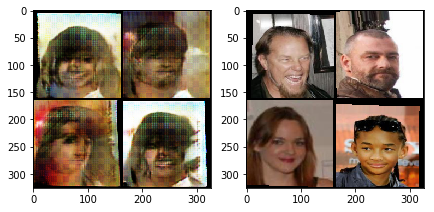

[0/1][12600/16884]	Loss_D: 1.1241	Loss_Dec: 3.0539	Aux F1: 0.8202	Loss_Enc: 2722.8391	D(x): 0.4298	D(G(z)): 0.2794
[0/1][12700/16884]	Loss_D: 1.1238	Loss_Dec: 3.0537	Aux F1: 0.8202	Loss_Enc: 2722.4723	D(x): 0.4807	D(G(z)): 0.2744
[0/1][12800/16884]	Loss_D: 1.1236	Loss_Dec: 3.0526	Aux F1: 0.8203	Loss_Enc: 2723.7020	D(x): 0.5355	D(G(z)): 0.2451
[0/1][12900/16884]	Loss_D: 1.1237	Loss_Dec: 3.0515	Aux F1: 0.8203	Loss_Enc: 2723.1922	D(x): 0.4959	D(G(z)): 0.2875
[0/1][13000/16884]	Loss_D: 1.1235	Loss_Dec: 3.0511	Aux F1: 0.8204	Loss_Enc: 2722.5687	D(x): 0.5399	D(G(z)): 0.2731


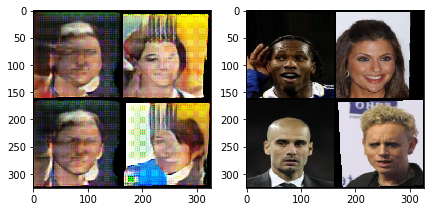

[0/1][13100/16884]	Loss_D: 1.1230	Loss_Dec: 3.0521	Aux F1: 0.8205	Loss_Enc: 2722.2778	D(x): 0.5789	D(G(z)): 0.2591
[0/1][13200/16884]	Loss_D: 1.1227	Loss_Dec: 3.0523	Aux F1: 0.8205	Loss_Enc: 2721.5808	D(x): 0.5334	D(G(z)): 0.2426
[0/1][13300/16884]	Loss_D: 1.1225	Loss_Dec: 3.0521	Aux F1: 0.8206	Loss_Enc: 2720.4864	D(x): 0.5188	D(G(z)): 0.3191
[0/1][13400/16884]	Loss_D: 1.1222	Loss_Dec: 3.0517	Aux F1: 0.8206	Loss_Enc: 2719.1175	D(x): 0.4273	D(G(z)): 0.2873
[0/1][13500/16884]	Loss_D: 1.1222	Loss_Dec: 3.0505	Aux F1: 0.8206	Loss_Enc: 2717.4881	D(x): 0.6131	D(G(z)): 0.1655


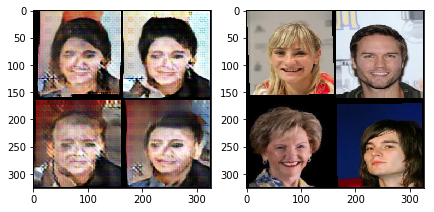

[0/1][13600/16884]	Loss_D: 1.1217	Loss_Dec: 3.0509	Aux F1: 0.8207	Loss_Enc: 2717.2063	D(x): 0.4815	D(G(z)): 0.2427
[0/1][13700/16884]	Loss_D: 1.1215	Loss_Dec: 3.0501	Aux F1: 0.8207	Loss_Enc: 2715.5990	D(x): 0.5526	D(G(z)): 0.2732
[0/1][13800/16884]	Loss_D: 1.1209	Loss_Dec: 3.0506	Aux F1: 0.8208	Loss_Enc: 2715.2940	D(x): 0.4612	D(G(z)): 0.2922
[0/1][13900/16884]	Loss_D: 1.1206	Loss_Dec: 3.0509	Aux F1: 0.8208	Loss_Enc: 2715.9392	D(x): 0.4541	D(G(z)): 0.2021
[0/1][14000/16884]	Loss_D: 1.1203	Loss_Dec: 3.0521	Aux F1: 0.8208	Loss_Enc: 2716.7839	D(x): 0.4390	D(G(z)): 0.3425


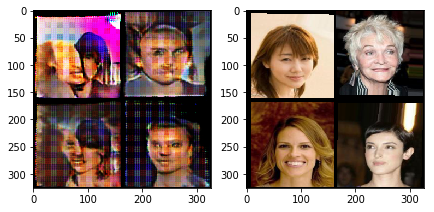

[0/1][14100/16884]	Loss_D: 1.1198	Loss_Dec: 3.0523	Aux F1: 0.8209	Loss_Enc: 2716.3993	D(x): 0.5372	D(G(z)): 0.2398
[0/1][14200/16884]	Loss_D: 1.1193	Loss_Dec: 3.0537	Aux F1: 0.8209	Loss_Enc: 2715.8514	D(x): 0.6101	D(G(z)): 0.2508
[0/1][14300/16884]	Loss_D: 1.1192	Loss_Dec: 3.0537	Aux F1: 0.8210	Loss_Enc: 2715.0379	D(x): 0.4368	D(G(z)): 0.2821
[0/1][14400/16884]	Loss_D: 1.1193	Loss_Dec: 3.0523	Aux F1: 0.8211	Loss_Enc: 2714.3169	D(x): 0.5905	D(G(z)): 0.2668
[0/1][14500/16884]	Loss_D: 1.1196	Loss_Dec: 3.0504	Aux F1: 0.8211	Loss_Enc: 2713.0349	D(x): 0.4043	D(G(z)): 0.3025


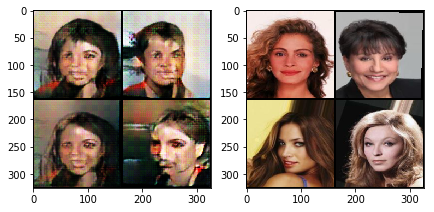

[0/1][14600/16884]	Loss_D: 1.1196	Loss_Dec: 3.0489	Aux F1: 0.8212	Loss_Enc: 2711.8314	D(x): 0.5192	D(G(z)): 0.2227
[0/1][14700/16884]	Loss_D: 1.1196	Loss_Dec: 3.0486	Aux F1: 0.8212	Loss_Enc: 2710.6055	D(x): 0.4505	D(G(z)): 0.3367
[0/1][14800/16884]	Loss_D: 1.1196	Loss_Dec: 3.0480	Aux F1: 0.8212	Loss_Enc: 2709.0853	D(x): 0.4481	D(G(z)): 0.3391
[0/1][14900/16884]	Loss_D: 1.1197	Loss_Dec: 3.0469	Aux F1: 0.8213	Loss_Enc: 2707.0066	D(x): 0.5247	D(G(z)): 0.2673
[0/1][15000/16884]	Loss_D: 1.1195	Loss_Dec: 3.0471	Aux F1: 0.8213	Loss_Enc: 2706.1516	D(x): 0.5450	D(G(z)): 0.1854


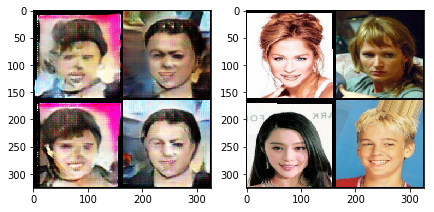

[0/1][15100/16884]	Loss_D: 1.1193	Loss_Dec: 3.0467	Aux F1: 0.8212	Loss_Enc: 2705.8578	D(x): 0.4936	D(G(z)): 0.2657
[0/1][15200/16884]	Loss_D: 1.1192	Loss_Dec: 3.0467	Aux F1: 0.8213	Loss_Enc: 2704.8014	D(x): 0.5608	D(G(z)): 0.2916
[0/1][15300/16884]	Loss_D: 1.1190	Loss_Dec: 3.0462	Aux F1: 0.8213	Loss_Enc: 2703.7346	D(x): 0.4804	D(G(z)): 0.3122
[0/1][15400/16884]	Loss_D: 1.1191	Loss_Dec: 3.0450	Aux F1: 0.8213	Loss_Enc: 2702.1806	D(x): 0.4212	D(G(z)): 0.3222
[0/1][15500/16884]	Loss_D: 1.1192	Loss_Dec: 3.0433	Aux F1: 0.8214	Loss_Enc: 2699.7293	D(x): 0.3851	D(G(z)): 0.3088


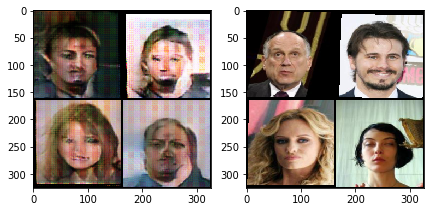

[0/1][15600/16884]	Loss_D: 1.1194	Loss_Dec: 3.0416	Aux F1: 0.8214	Loss_Enc: 2699.4644	D(x): 0.5329	D(G(z)): 0.2541
[0/1][15700/16884]	Loss_D: 1.1193	Loss_Dec: 3.0406	Aux F1: 0.8214	Loss_Enc: 2700.0960	D(x): 0.5440	D(G(z)): 0.2369
[0/1][15800/16884]	Loss_D: 1.1195	Loss_Dec: 3.0391	Aux F1: 0.8214	Loss_Enc: 2699.6487	D(x): 0.4789	D(G(z)): 0.2196
[0/1][15900/16884]	Loss_D: 1.1196	Loss_Dec: 3.0374	Aux F1: 0.8214	Loss_Enc: 2697.7908	D(x): 0.4293	D(G(z)): 0.3590
[0/1][16000/16884]	Loss_D: 1.1193	Loss_Dec: 3.0368	Aux F1: 0.8215	Loss_Enc: 2696.1927	D(x): 0.4422	D(G(z)): 0.3104


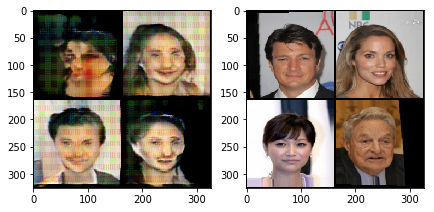

[0/1][16100/16884]	Loss_D: 1.1194	Loss_Dec: 3.0351	Aux F1: 0.8215	Loss_Enc: 2694.6831	D(x): 0.3951	D(G(z)): 0.3494
[0/1][16200/16884]	Loss_D: 1.1195	Loss_Dec: 3.0338	Aux F1: 0.8215	Loss_Enc: 2693.5166	D(x): 0.4842	D(G(z)): 0.2797
[0/1][16300/16884]	Loss_D: 1.1195	Loss_Dec: 3.0333	Aux F1: 0.8215	Loss_Enc: 2692.8007	D(x): 0.4098	D(G(z)): 0.2893
[0/1][16400/16884]	Loss_D: 1.1195	Loss_Dec: 3.0327	Aux F1: 0.8215	Loss_Enc: 2693.8592	D(x): 0.5020	D(G(z)): 0.2917
Interrupting... Saving model...
Copying file://./vaegan_dn169_1.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who 

In [0]:
train(net, n_epochs=1)

[0/1][0/16884]	Loss_D: 1.1859	Loss_Dec: 3.0823	Aux F1: 0.8458	Loss_Enc: 2860.0962	D(x): 0.4525	D(G(z)): 0.2752
[0/1][100/16884]	Loss_D: 1.1505	Loss_Dec: 2.8900	Aux F1: 0.8220	Loss_Enc: 2664.7647	D(x): 0.4486	D(G(z)): 0.3566
[0/1][200/16884]	Loss_D: 1.1677	Loss_Dec: 2.9269	Aux F1: 0.8238	Loss_Enc: 2617.8076	D(x): 0.4232	D(G(z)): 0.3564
[0/1][300/16884]	Loss_D: 1.1639	Loss_Dec: 2.9769	Aux F1: 0.8242	Loss_Enc: 2617.6934	D(x): 0.4704	D(G(z)): 0.3042
[0/1][400/16884]	Loss_D: 1.1596	Loss_Dec: 3.0123	Aux F1: 0.8246	Loss_Enc: 2630.3707	D(x): 0.4508	D(G(z)): 0.3015
[0/1][500/16884]	Loss_D: 1.1524	Loss_Dec: 3.0400	Aux F1: 0.8246	Loss_Enc: 2630.7290	D(x): 0.3884	D(G(z)): 0.3459


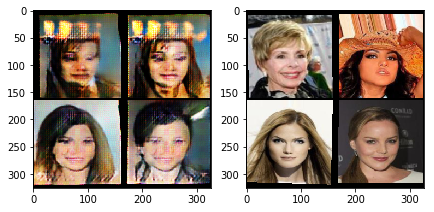

[0/1][600/16884]	Loss_D: 1.1473	Loss_Dec: 3.0677	Aux F1: 0.8247	Loss_Enc: 2626.8724	D(x): 0.5302	D(G(z)): 0.1941
[0/1][700/16884]	Loss_D: 1.1416	Loss_Dec: 3.0826	Aux F1: 0.8255	Loss_Enc: 2626.0220	D(x): 0.5815	D(G(z)): 0.2905
[0/1][800/16884]	Loss_D: 1.1355	Loss_Dec: 3.0997	Aux F1: 0.8256	Loss_Enc: 2622.8908	D(x): 0.4698	D(G(z)): 0.3491
[0/1][900/16884]	Loss_D: 1.1346	Loss_Dec: 3.1098	Aux F1: 0.8261	Loss_Enc: 2620.4420	D(x): 0.5116	D(G(z)): 0.2436
[0/1][1000/16884]	Loss_D: 1.1362	Loss_Dec: 3.1139	Aux F1: 0.8262	Loss_Enc: 2617.1864	D(x): 0.3754	D(G(z)): 0.3241


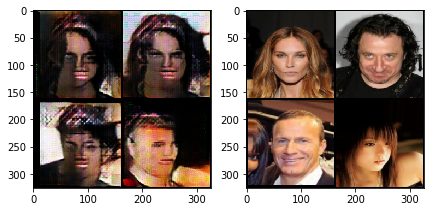

[0/1][1100/16884]	Loss_D: 1.1347	Loss_Dec: 3.1115	Aux F1: 0.8263	Loss_Enc: 2616.7185	D(x): 0.4394	D(G(z)): 0.3466
[0/1][1200/16884]	Loss_D: 1.1369	Loss_Dec: 3.1005	Aux F1: 0.8264	Loss_Enc: 2608.7579	D(x): 0.4159	D(G(z)): 0.3318
[0/1][1300/16884]	Loss_D: 1.1372	Loss_Dec: 3.0896	Aux F1: 0.8267	Loss_Enc: 2601.9763	D(x): 0.5320	D(G(z)): 0.2606
[0/1][1400/16884]	Loss_D: 1.1378	Loss_Dec: 3.0923	Aux F1: 0.8269	Loss_Enc: 2604.3036	D(x): 0.3793	D(G(z)): 0.3403
[0/1][1500/16884]	Loss_D: 1.1382	Loss_Dec: 3.0924	Aux F1: 0.8270	Loss_Enc: 2611.5571	D(x): 0.4640	D(G(z)): 0.3027


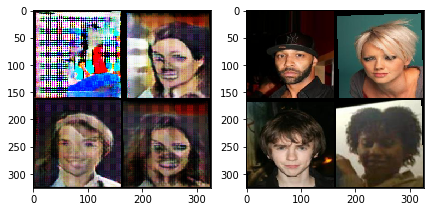

[0/1][1600/16884]	Loss_D: 1.1380	Loss_Dec: 3.0921	Aux F1: 0.8270	Loss_Enc: 2619.8477	D(x): 0.4795	D(G(z)): 0.2882
[0/1][1700/16884]	Loss_D: 1.1361	Loss_Dec: 3.0949	Aux F1: 0.8270	Loss_Enc: 2628.5260	D(x): 0.5819	D(G(z)): 0.2020
[0/1][1800/16884]	Loss_D: 1.1335	Loss_Dec: 3.1061	Aux F1: 0.8274	Loss_Enc: 2634.5072	D(x): 0.4563	D(G(z)): 0.2530
[0/1][1900/16884]	Loss_D: 1.1341	Loss_Dec: 3.1076	Aux F1: 0.8274	Loss_Enc: 2634.5486	D(x): 0.4593	D(G(z)): 0.2827
[0/1][2000/16884]	Loss_D: 1.1340	Loss_Dec: 3.1110	Aux F1: 0.8273	Loss_Enc: 2640.4923	D(x): 0.5955	D(G(z)): 0.2236


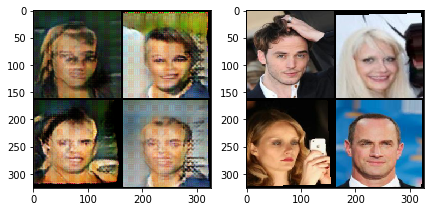

[0/1][2100/16884]	Loss_D: 1.1329	Loss_Dec: 3.1134	Aux F1: 0.8274	Loss_Enc: 2646.5166	D(x): 0.5404	D(G(z)): 0.2680
[0/1][2200/16884]	Loss_D: 1.1318	Loss_Dec: 3.1178	Aux F1: 0.8276	Loss_Enc: 2651.2104	D(x): 0.5733	D(G(z)): 0.2141
[0/1][2300/16884]	Loss_D: 1.1331	Loss_Dec: 3.1176	Aux F1: 0.8279	Loss_Enc: 2652.3475	D(x): 0.3557	D(G(z)): 0.3417
[0/1][2400/16884]	Loss_D: 1.1338	Loss_Dec: 3.1162	Aux F1: 0.8279	Loss_Enc: 2657.3431	D(x): 0.4909	D(G(z)): 0.3344
[0/1][2500/16884]	Loss_D: 1.1348	Loss_Dec: 3.1170	Aux F1: 0.8279	Loss_Enc: 2664.8678	D(x): 0.5026	D(G(z)): 0.3141


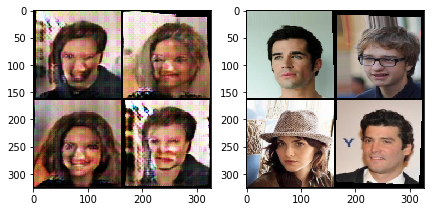

[0/1][2600/16884]	Loss_D: 1.1358	Loss_Dec: 3.1143	Aux F1: 0.8278	Loss_Enc: 2666.0454	D(x): 0.4754	D(G(z)): 0.3113
[0/1][2700/16884]	Loss_D: 1.1367	Loss_Dec: 3.1121	Aux F1: 0.8280	Loss_Enc: 2665.6785	D(x): 0.4297	D(G(z)): 0.2531
[0/1][2800/16884]	Loss_D: 1.1370	Loss_Dec: 3.1101	Aux F1: 0.8278	Loss_Enc: 2669.9106	D(x): 0.4065	D(G(z)): 0.3702
[0/1][2900/16884]	Loss_D: 1.1381	Loss_Dec: 3.1105	Aux F1: 0.8275	Loss_Enc: 2676.3486	D(x): 0.5806	D(G(z)): 0.2102
[0/1][3000/16884]	Loss_D: 1.1390	Loss_Dec: 3.1106	Aux F1: 0.8274	Loss_Enc: 2681.4711	D(x): 0.5065	D(G(z)): 0.2577


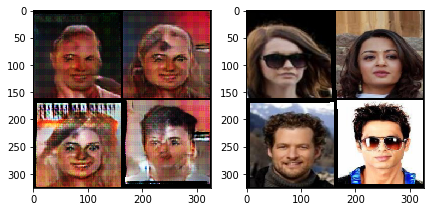

[0/1][3100/16884]	Loss_D: 1.1384	Loss_Dec: 3.1138	Aux F1: 0.8273	Loss_Enc: 2688.3853	D(x): 0.4494	D(G(z)): 0.2343
[0/1][3200/16884]	Loss_D: 1.1378	Loss_Dec: 3.1155	Aux F1: 0.8273	Loss_Enc: 2692.7558	D(x): 0.4398	D(G(z)): 0.2673
[0/1][3300/16884]	Loss_D: 1.1381	Loss_Dec: 3.1159	Aux F1: 0.8274	Loss_Enc: 2696.6461	D(x): 0.4256	D(G(z)): 0.3210
[0/1][3400/16884]	Loss_D: 1.1390	Loss_Dec: 3.1155	Aux F1: 0.8274	Loss_Enc: 2699.6488	D(x): 0.4650	D(G(z)): 0.2429
[0/1][3500/16884]	Loss_D: 1.1392	Loss_Dec: 3.1147	Aux F1: 0.8274	Loss_Enc: 2701.5870	D(x): 0.4013	D(G(z)): 0.3062


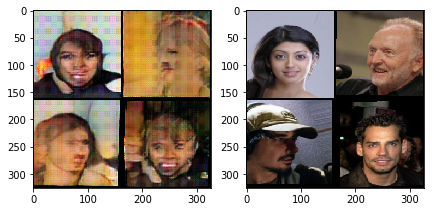

[0/1][3600/16884]	Loss_D: 1.1401	Loss_Dec: 3.1136	Aux F1: 0.8272	Loss_Enc: 2706.1105	D(x): 0.4965	D(G(z)): 0.2864
[0/1][3700/16884]	Loss_D: 1.1419	Loss_Dec: 3.1104	Aux F1: 0.8271	Loss_Enc: 2706.8421	D(x): 0.4806	D(G(z)): 0.3136
[0/1][3800/16884]	Loss_D: 1.1427	Loss_Dec: 3.1089	Aux F1: 0.8271	Loss_Enc: 2709.3703	D(x): 0.4410	D(G(z)): 0.3167
[0/1][3900/16884]	Loss_D: 1.1426	Loss_Dec: 3.1107	Aux F1: 0.8271	Loss_Enc: 2712.7136	D(x): 0.3325	D(G(z)): 0.4117
[0/1][4000/16884]	Loss_D: 1.1438	Loss_Dec: 3.1097	Aux F1: 0.8271	Loss_Enc: 2715.6149	D(x): 0.3492	D(G(z)): 0.2917


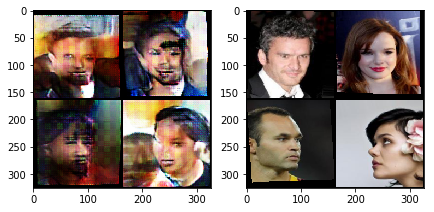

[0/1][4100/16884]	Loss_D: 1.1432	Loss_Dec: 3.1113	Aux F1: 0.8270	Loss_Enc: 2719.1949	D(x): 0.4843	D(G(z)): 0.1892
[0/1][4200/16884]	Loss_D: 1.1431	Loss_Dec: 3.1120	Aux F1: 0.8270	Loss_Enc: 2726.7669	D(x): 0.4238	D(G(z)): 0.3276
[0/1][4300/16884]	Loss_D: 1.1436	Loss_Dec: 3.1118	Aux F1: 0.8269	Loss_Enc: 2734.6795	D(x): 0.4231	D(G(z)): 0.3530
[0/1][4400/16884]	Loss_D: 1.1440	Loss_Dec: 3.1090	Aux F1: 0.8268	Loss_Enc: 2739.4721	D(x): 0.4225	D(G(z)): 0.2644
[0/1][4500/16884]	Loss_D: 1.1443	Loss_Dec: 3.1095	Aux F1: 0.8267	Loss_Enc: 2749.5110	D(x): 0.4679	D(G(z)): 0.2755


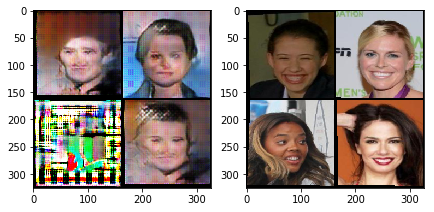

[0/1][4600/16884]	Loss_D: 1.1451	Loss_Dec: 3.1086	Aux F1: 0.8267	Loss_Enc: 2753.9882	D(x): 0.3859	D(G(z)): 0.3230
[0/1][4700/16884]	Loss_D: 1.1451	Loss_Dec: 3.1094	Aux F1: 0.8266	Loss_Enc: 2759.3003	D(x): 0.4794	D(G(z)): 0.3341
[0/1][4800/16884]	Loss_D: 1.1458	Loss_Dec: 3.1107	Aux F1: 0.8266	Loss_Enc: 2764.6864	D(x): 0.4800	D(G(z)): 0.2896
[0/1][4900/16884]	Loss_D: 1.1453	Loss_Dec: 3.1133	Aux F1: 0.8265	Loss_Enc: 2770.6625	D(x): 0.4769	D(G(z)): 0.3174
[0/1][5000/16884]	Loss_D: 1.1457	Loss_Dec: 3.1139	Aux F1: 0.8266	Loss_Enc: 2776.8667	D(x): 0.4901	D(G(z)): 0.3368


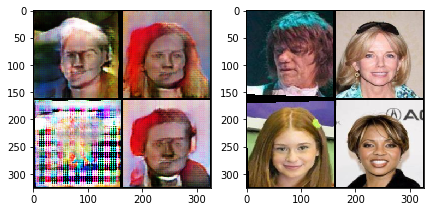

[0/1][5100/16884]	Loss_D: 1.1455	Loss_Dec: 3.1149	Aux F1: 0.8265	Loss_Enc: 2781.6534	D(x): 0.4906	D(G(z)): 0.1806
[0/1][5200/16884]	Loss_D: 1.1443	Loss_Dec: 3.1142	Aux F1: 0.8265	Loss_Enc: 2780.4789	D(x): 0.5074	D(G(z)): 0.2443
[0/1][5300/16884]	Loss_D: 1.1437	Loss_Dec: 3.1154	Aux F1: 0.8265	Loss_Enc: 2778.1886	D(x): 0.4879	D(G(z)): 0.3279
[0/1][5400/16884]	Loss_D: 1.1430	Loss_Dec: 3.1155	Aux F1: 0.8265	Loss_Enc: 2776.4332	D(x): 0.5015	D(G(z)): 0.2810
[0/1][5500/16884]	Loss_D: 1.1414	Loss_Dec: 3.1172	Aux F1: 0.8265	Loss_Enc: 2773.3239	D(x): 0.4133	D(G(z)): 0.2766


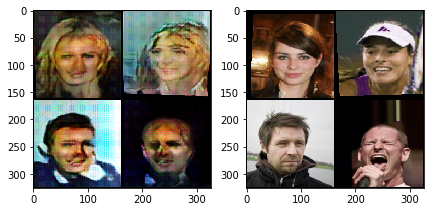

[0/1][5600/16884]	Loss_D: 1.1413	Loss_Dec: 3.1140	Aux F1: 0.8264	Loss_Enc: 2764.9732	D(x): 0.3739	D(G(z)): 0.3824
[0/1][5700/16884]	Loss_D: 1.1408	Loss_Dec: 3.1092	Aux F1: 0.8263	Loss_Enc: 2766.2497	D(x): 0.4382	D(G(z)): 0.3172
[0/1][5800/16884]	Loss_D: 1.1410	Loss_Dec: 3.1030	Aux F1: 0.8262	Loss_Enc: 2764.3073	D(x): 0.5008	D(G(z)): 0.2494
[0/1][5900/16884]	Loss_D: 1.1410	Loss_Dec: 3.0975	Aux F1: 0.8261	Loss_Enc: 2768.5346	D(x): 0.4483	D(G(z)): 0.2960
[0/1][6000/16884]	Loss_D: 1.1413	Loss_Dec: 3.0914	Aux F1: 0.8260	Loss_Enc: 2762.9526	D(x): 0.4515	D(G(z)): 0.2862


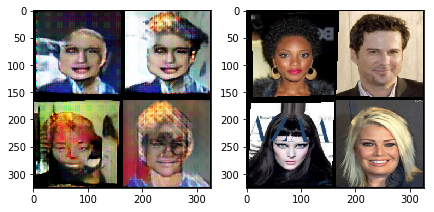

[0/1][6100/16884]	Loss_D: 1.1408	Loss_Dec: 3.0890	Aux F1: 0.8261	Loss_Enc: 2758.5790	D(x): 0.5640	D(G(z)): 0.2971
[0/1][6200/16884]	Loss_D: 1.1410	Loss_Dec: 3.0831	Aux F1: 0.8260	Loss_Enc: 2757.8696	D(x): 0.4624	D(G(z)): 0.3110
[0/1][6300/16884]	Loss_D: 1.1411	Loss_Dec: 3.0771	Aux F1: 0.8261	Loss_Enc: 2760.4210	D(x): 0.3773	D(G(z)): 0.2635
[0/1][6400/16884]	Loss_D: 1.1407	Loss_Dec: 3.0730	Aux F1: 0.8259	Loss_Enc: 2773.8669	D(x): 0.5130	D(G(z)): 0.3205
[0/1][6500/16884]	Loss_D: 1.1415	Loss_Dec: 3.0664	Aux F1: 0.8258	Loss_Enc: 2774.4273	D(x): 0.3873	D(G(z)): 0.3188


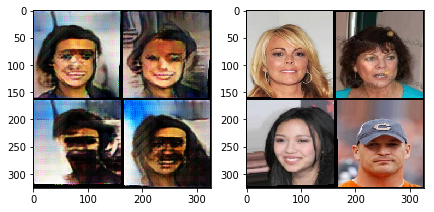

[0/1][6600/16884]	Loss_D: 1.1413	Loss_Dec: 3.0610	Aux F1: 0.8258	Loss_Enc: 2776.2912	D(x): 0.4320	D(G(z)): 0.3317


In [0]:
train(net, n_epochs=1)

In [0]:
train(net, n_epochs=1)

In [0]:
for j, (data_batch,target_batch) in enumerate(train_loader):
    # encoding = net.encoder(data_batch.cuda())
    disc = net.discriminator(data_batch.cuda())
    break